In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch

In [2]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator
from diffusers import (
    PNDMScheduler,
    DDIMScheduler,
    DDPMScheduler,
    DPMSolverMultistepScheduler,
    KDPM2DiscreteScheduler,
    DEISMultistepScheduler,
)

from pts.model.time_grad import TimeGradEstimator
from pts.dataset.repository.datasets import dataset_recipes

In [3]:
import pts
print(pts.__version__)

1.4.8


## Prepeare data set

In [4]:
dataset = get_dataset("electricity_nips", regenerate=False)

In [5]:
dataset.metadata

MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='370')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24)

In [6]:
dataset

TrainDatasets(metadata=MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='370')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24), train=Map(fn=<gluonts.dataset.common.ProcessDataEntry object at 0x7f475c896880>, iterable=JsonLinesFile(path=PosixPath('/home/bsj/.gluonts/datasets/electricity_nips/train/data.json.gz'), start=0, n=None, line_starts=[0, 106547, 218864, 329753, 441833, 554246, 667460, 777538, 887091, 999727, 1106026, 1218441, 1325745, 1432746, 1546075, 1655642, 1764629, 1877440, 1982881, 2093439, 2205981, 2317042, 2423347, 2471215, 2581120, 2692144, 2802568, 2892838, 3001168, 3113731, 3226717, 3340199, 3452491, 3560135, 3665790, 3777752, 3887630, 3940919, 4035680, 4147967, 4256411, 4276754, 4385700, 4495785, 4607344, 4718913, 4823183, 4936307, 5048960, 5162272, 5275066, 5374145, 5487383, 5597588, 5710483, 5820342, 5932455, 6045438, 6156612, 6269227, 6382443, 6492196, 6605386, 67

In [7]:
train_grouper = MultivariateGrouper(
    max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality)
)

test_grouper = MultivariateGrouper(
    num_test_dates=int(len(dataset.test) / len(dataset.train)),
    max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
)

In [8]:
dataset_train = train_grouper(dataset.train)
dataset_test = test_grouper(dataset.test)

In [9]:
dataset_train

[{'target': array([[115.27613 , 115.27613 , 115.27613 , ...,  71.42857 ,  52.99539 ,
           52.419353],
         [175.53192 , 164.89362 , 154.78723 , ..., 128.7234  , 129.78723 ,
          116.489365],
         [ 31.993204,  31.28539 ,  31.568516, ...,  63.703285,  45.58324 ,
           41.19479 ],
         ...,
         [ 90.3149  ,  93.01075 ,  90.31874 , ..., 139.51228 , 111.4593  ,
          114.91551 ],
         [114.57534 , 120.746574, 126.23288 , ..., 238.14383 , 137.887   ,
          132.05821 ],
         [ 47.912006,  46.234154,  47.53915 , ...,  90.23117 ,  66.74124 ,
           59.470543]], dtype=float32),
  'start': Period('2014-01-01 00:00', 'H'),
  'feat_static_cat': array([0], dtype=int32)}]

In [10]:
def plot(
    target,
    forecast,
    prediction_length,
    prediction_intervals=(50.0, 90.0),
    color="g",
    fname=None,
):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape

    ps = [50.0] + [
        50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
    ]

    percentiles_sorted = sorted(set(ps))

    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3

    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)

        ps_data = [forecast.quantile(p / 100.0)[:, dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2

        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)

        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [
        f"{k}% prediction interval" for k in prediction_intervals
    ][::-1]
    axx[0].legend(legend, loc="upper left")

    if fname is not None:
        plt.savefig(fname, bbox_inches="tight", pad_inches=0.05)

## Evaluator

In [11]:
evaluator = MultivariateEvaluator(
    quantiles=(np.arange(20) / 20.0)[1:], target_agg_funcs={"sum": np.sum}
)

## `TimeGrad`

In [12]:
# scheduler = PNDMScheduler(
#     num_train_timesteps=100,
#     beta_end=0.2,
#     beta_schedule="squaredcos_cap_v2",
# )

In [13]:
scheduler = DDPMScheduler(
    num_train_timesteps=100,
    beta_end=0.1,
    beta_schedule="squaredcos_cap_v2",
    thresholding=True,
    clip_sample=False,
)

In [14]:
# scheduler = DEISMultistepScheduler(
#     num_train_timesteps=150,
#     beta_end=0.1,
# )

In [15]:
# device = "cuda" if torch.cuda.is_available() else "CPU"

In [16]:
estimator = TimeGradEstimator(
    input_size=int(dataset.metadata.feat_static_cat[0].cardinality),
    hidden_size=64,
    num_layers=2,
    dropout_rate=0.1,
    lags_seq=[1],
    scheduler=scheduler,
    num_inference_steps=10,
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length * 3,
    freq=dataset.metadata.freq,
    scaling="mean",
    trainer_kwargs=dict(max_epochs=200, accelerator="gpu"),
)

In [17]:
predictor = estimator.train(dataset_train, cache_data=True, shuffle_buffer_length=1024)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/bsj/.local/lib/python3.8/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params | In sizes                                                             | Out sizes        
---------------------------------------------------------------------------------------------------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 0.38144 (best 0.38144), saving model to '/home/bsj/workspace/pytorch-ts/examples/lightning_logs/version_25/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 0.15831 (best 0.15831), saving model to '/home/bsj/workspace/pytorch-ts/examples/lightning_logs/version_25/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 0.11041 (best 0.11041), saving model to '/home/bsj/workspace/pytorch-ts/examples/lightning_logs/version_25/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 0.09028 (best 0.09028), saving model to '/home/bsj/workspace/pytorch-ts/examples/lightning_logs/version_25/checkpoints/epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 0.08097 (best 0.08097), saving model to '/home/bsj/workspace/pytorch-ts/examples/lightning_logs/version_25/checkpoints/epoch=4-step=250.ckpt' as top 1
Epoch 5, glo

In [18]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset_test, predictor=predictor, num_samples=100
)
forecasts = list(forecast_it)
targets = list(ts_it)
agg_metric, _ = evaluator(targets, forecasts, num_series=len(dataset_test))

Running evaluation: 7it [00:00, 263.44it/s]
Running evaluation: 7it [00:00, 279.43it/s]
Running evaluation: 7it [00:00, 272.86it/s]
Running evaluation: 7it [00:00, 301.23it/s]
Running evaluation: 7it [00:00, 285.16it/s]
Running evaluation: 7it [00:00, 273.10it/s]
Running evaluation: 7it [00:00, 275.89it/s]
Running evaluation: 7it [00:00, 286.66it/s]
Running evaluation: 7it [00:00, 282.64it/s]
Running evaluation: 7it [00:00, 283.96it/s]
Running evaluation: 7it [00:00, 278.55it/s]
Running evaluation: 7it [00:00, 286.74it/s]
Running evaluation: 7it [00:00, 275.36it/s]
Running evaluation: 7it [00:00, 279.56it/s]
Running evaluation: 7it [00:00, 278.04it/s]
Running evaluation: 7it [00:00, 295.95it/s]
Running evaluation: 7it [00:00, 291.84it/s]
Running evaluation: 7it [00:00, 273.02it/s]
Running evaluation: 7it [00:00, 278.72it/s]
Running evaluation: 7it [00:00, 271.58it/s]
Running evaluation: 7it [00:00, 273.04it/s]
Running evaluation: 7it [00:00, 286.09it/s]
Running evaluation: 7it [00:00, 

### Metrics

In [19]:
print("CRPS: {}".format(agg_metric["mean_wQuantileLoss"]))
print("ND: {}".format(agg_metric["ND"]))
print("NRMSE: {}".format(agg_metric["NRMSE"]))
print("MSE: {}".format(agg_metric["MSE"]))

CRPS: 0.2096742858701175
ND: 0.21497207527584436
NRMSE: 2.367709181357584
MSE: 3210882.5167625253


In [20]:
print("CRPS-Sum: {}".format(agg_metric["m_sum_mean_wQuantileLoss"]))
print("ND-Sum: {}".format(agg_metric["m_sum_ND"]))
print("NRMSE-Sum: {}".format(agg_metric["m_sum_NRMSE"]))
print("MSE-Sum: {}".format(agg_metric["m_sum_MSE"]))

CRPS-Sum: 0.1920313004151189
ND-Sum: 0.19443540720120986
NRMSE-Sum: 0.25717322443788493
MSE-Sum: 5185882355.809524


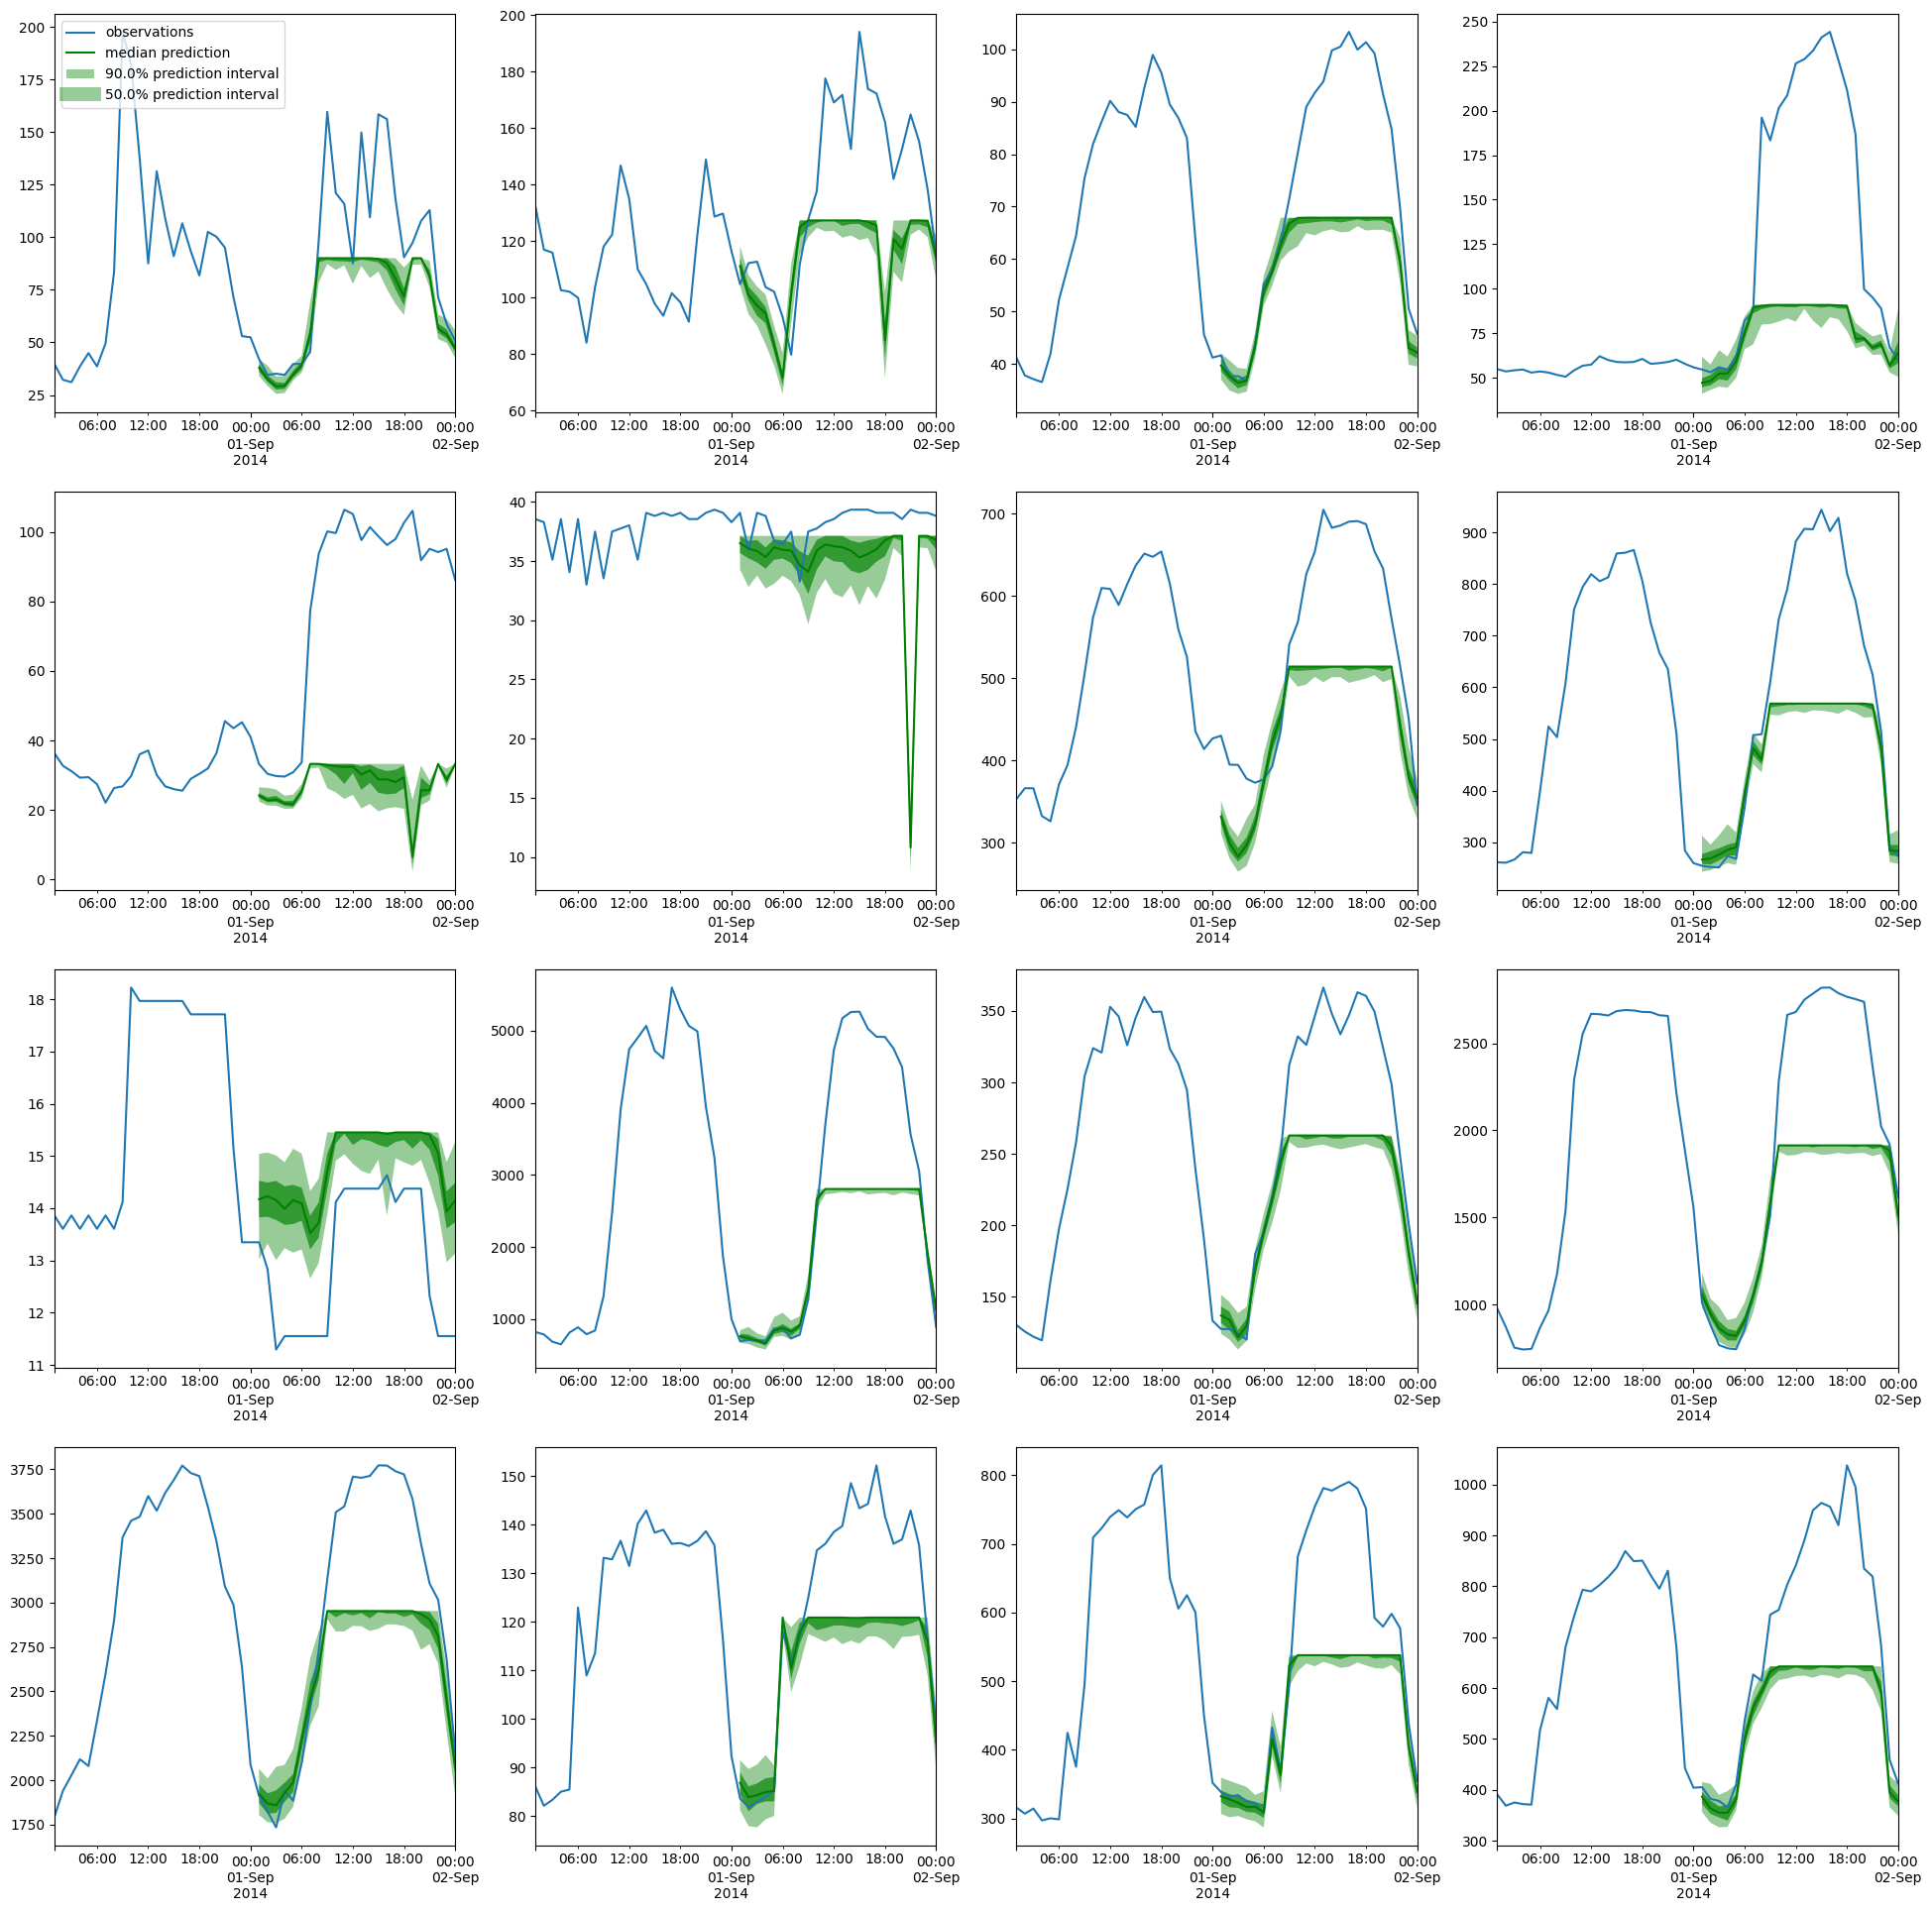

In [21]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=dataset.metadata.prediction_length,
)
plt.show()